# Fastai with HuggingFace 🤗 Transformers (XLNet)


## Libraries Installation


In [1]:
!pip install -q transformers
#pip install torch


     |████████████████████████████████| 1.3MB 5.0MB/s 
     |████████████████████████████████| 1.1MB 27.9MB/s 
     |████████████████████████████████| 2.9MB 48.2MB/s 
     |████████████████████████████████| 890kB 48.6MB/s 


In [4]:
#!pip install fastai


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig


The current versions of the fastai and transformers libraries are respectively 1.0.58 and 2.5.1.

In [6]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 3.4.0


In [120]:
DATA_ROOT = Path("dataset") #/ "/kaggle/input/sentiment-analysis-on-movie-reviews"
train = pd.read_csv(DATA_ROOT / 'hateval2019_es_train.csv')
test = pd.read_csv(DATA_ROOT / 'hateval2019_es_dev.csv')
print(train.shape,test.shape)
train.head()

(4500, 5) (500, 5)


,id,text,HS,TR,AG
0,20001,Easyjet quiere duplicar el número de mujeres p...,1,0,0
1,20002,El gobierno debe crear un control estricto de ...,1,0,0
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0,0,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0,0,0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0,0,0


## Main transformers classes


In [121]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [122]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'xlnet'
pretrained_model_name = 'xlnet-base-cased'


In [123]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

Print the available values for ``pretrained_model_name`` (shortcut names) corresponding to the ``model_type`` used.

In [ ]:
#model_class.pretrained_model_archive_map.keys()

## Util function

Function to set the seed for generating random numbers.

In [124]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [125]:
seed_all(seed)

## Data pre-processing


### Custom Tokenizer


In [126]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [127]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1374: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


### Custom Numericalizer


In [128]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


### Custom processor


In [129]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch


In [130]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id


In [ ]:
#pad_first
#pad_idx

In [131]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['▁Sal', 'ut', '▁c', '▁', 'est', '▁mo', 'i', ',', '▁', 'Hello', '▁it', '▁', 's', '▁me']
[4943, 2015, 2349, 17, 1277, 6353, 150, 19, 17, 11368, 36, 17, 23, 110]


['▁Sal',
 'ut',
 '▁c',
 '▁',
 'est',
 '▁mo',
 'i',
 ',',
 '▁',
 'Hello',
 '▁it',
 '▁',
 's',
 '▁me']

There is multible ways to create a DataBunch, in our implementation, we use [the data block API](https://docs.fast.ai/data_block.html#The-data-block-API), which gives more flexibility.

In [199]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'AG')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Check batch and tokenizer :

In [200]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <cls>
[SEP] token : <sep>
[PAD] token : <pad>


text,target
"▁DE ▁ NU EST RA S ▁ GU ER RA S , ▁L OS ▁ ASE S IN OS ▁NO S ▁ TA EN ▁ S US ▁ GU ER RA S ▁ EN ▁ NU EST RA S ▁T IE RR AS ▁Y ▁ NU EST RA ▁ ES ▁CON ▁LA ▁D IC TA DU RA ▁F RAN QUI STA . . . . . ▁Y A ▁ HA",1
"<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ▁ ( 3 ) ▁la ▁ # char la ▁de ▁ # Mu ham mad , se ▁ # dis ting ue ▁por ▁ el ▁ # est ilo ▁de ▁ los ▁ # dia log os , ▁de ▁ las ▁ # ex plica cion es , ▁de ▁ # ap re",0
"<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ▁Y ▁por ▁la ▁ PE DER AST IA , ▁VI OL AC ION ▁ y ▁A CO SO ▁I MB EC IL ▁ @ S ando val I ni gue z ? ? ▁Por ▁ es os ▁ PE CAD OS ▁DE BER IA ▁ TE MB LAR ▁ TU ▁I G",0
"<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ▁ "" A ▁cm s . ▁de ▁a trop ella r me ▁un ▁tip o , ▁ es ▁IN MI GRA N TE , ▁ m ient ras , ▁ cru za ba ▁la ▁call e ▁con ▁ lu z ▁ ver de . ▁Le ▁in d ique ▁ hab ia",0
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ▁LA ▁IN MI GRA C ION ▁DE ▁A FR ICA ▁Y ▁P AIS ES ▁ ARE BE S ▁ ES ▁UN A ▁ EST RATE G IA ▁P ARA ▁ ENT RA R ▁A ▁ EURO PA ▁Y ▁ ATA CAR LA ▁ DES DE ▁D ENT RO ▁COM O ▁H,0


Check batch and numericalizer :

In [201]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 3
[SEP] id : 4
[PAD] id : 5
Batch shape :  torch.Size([16, 168])
tensor([[10241,    17, 13997,  ..., 10544,     4,     3],
        [    5,     5,     5,  ...,    98,     4,     3],
        [    5,     5,     5,  ...,  1940,     4,     3],
        ...,
        [    5,     5,     5,  ...,  4675,     4,     3],
        [    5,     5,     5,  ...,   695,     4,     3],
        [    5,     5,     5,  ...,  1940,     4,     3]])


### Custom model


In [202]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [203]:
config = config_class.from_pretrained(pretrained_model_name)
#config.num_labels = 5
config.num_labels = 3
config.use_bfloat16 = use_fp16
print(config)

XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "untie_r": true,
  "vocab_size": 32000
}



/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `mem_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


In [204]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

## Learner : Custom Optimizer / Custom Metric


In [205]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

## Discriminative Fine-tuning and Gradual unfreezing (Optional)


In [58]:
#print(learner.model)

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

In this case, we can split our model in this way :

In [206]:

# For xlnet-base-cased
list_layers = [learner.model.transformer.transformer.word_embedding,
               learner.model.transformer.transformer.layer[0],
               learner.model.transformer.transformer.layer[1],
               learner.model.transformer.transformer.layer[2],
               learner.model.transformer.transformer.layer[3],
               learner.model.transformer.transformer.layer[4],
               learner.model.transformer.transformer.layer[5],
               learner.model.transformer.transformer.layer[6],
               learner.model.transformer.transformer.layer[7],
               learner.model.transformer.transformer.layer[8],
               learner.model.transformer.transformer.layer[9],
               learner.model.transformer.transformer.layer[10],
               learner.model.transformer.transformer.layer[11],
               learner.model.transformer.sequence_summary]


Check groups : 

In [207]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(32000, 768)
), Sequential(
  (0): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ParameterModule()
  (3): ParameterModule()
  (4): ParameterModule()
  (5): ParameterModule()
  (6): ParameterModule()
  (7): ParameterModule()
  (8): ParameterModule()
  (9): ParameterModule()
  (10): ParameterModule()
  (11): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (12): Linear(in_features=768, out_features=3072, bias=True)
  (13): Linear(in_features=3072, out_features=768, bias=True)
  (14): Dropout(p=0.1, inplace=False)
  (15): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ParameterModule()
  (3): ParameterModule()
  (4): ParameterModule()
  (5): ParameterModule()
  (6): ParameterModule()
  (7): ParameterModule()
  (8): ParameterModule()
  (9): ParameterModule()
  (10): Parameter

## Train


In [208]:
learner.save('untrain')

In [209]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [210]:
learner.freeze_to(-1)

We check which layer are trainable.

In [65]:
#learner.summary()

For **Slanted Triangular Learning Rates** you have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [211]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-05
Min loss divided by 10: 5.75E-05


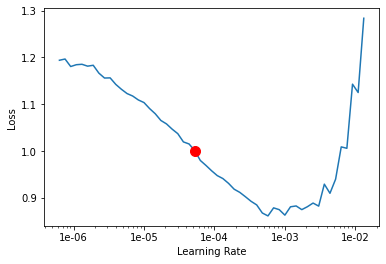

In [212]:
learner.recorder.plot(skip_end=10,suggestion=True)

We will pick a value a bit before the minimum, where the loss still improves. Here 2x10^-3 seems to be a good value.

Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.677273,0.637204,0.668889,0.331111,00:27


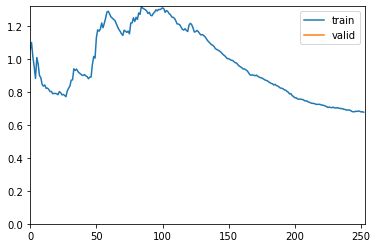

In [213]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [214]:
learner.save('first_cycle')

In [215]:
seed_all(seed)
learner.load('first_cycle');

We then unfreeze the second group of layers and repeat the operations.

In [216]:
learner.freeze_to(-2)

In [217]:
lr = 1e-5

Note here that we use slice to create separate learning rate for each group.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.604442,0.622898,0.680000,0.320000,00:29
1,0.598788,0.615240,0.684444,0.315556,00:32


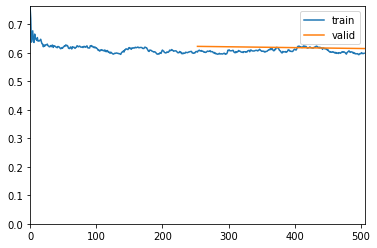

In [218]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [219]:
learner.save('second_cycle')

In [220]:
seed_all(seed)
learner.load('second_cycle');

In [221]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.563129,0.624972,0.684444,0.315556,00:32
1,0.578337,0.598537,0.700000,0.300000,00:35
2,0.576397,0.590892,0.704444,0.295556,00:35


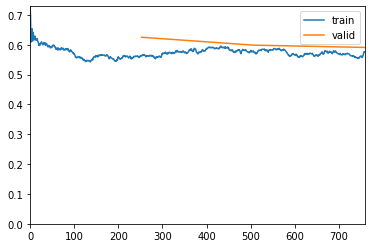

In [222]:
learner.fit_one_cycle(3, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [223]:
learner.save('third_cycle')

In [224]:
seed_all(seed)
learner.load('third_cycle');

In [225]:
learner.freeze_to(-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.446006,0.667121,0.657778,0.342222,00:37
1,0.501102,0.623775,0.695556,0.304444,00:38
2,0.556995,0.572463,0.706667,0.293333,00:40
3,0.530570,0.570920,0.700000,0.300000,00:38


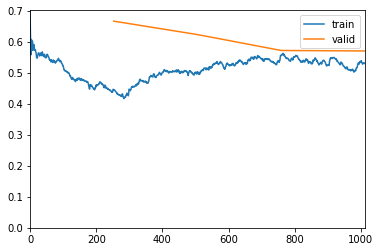

In [226]:
learner.fit_one_cycle(4, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [227]:
learner.save('fourth_cycle')

In [228]:
seed_all(seed)
learner.load('fourth_cycle');

Here, we unfreeze all the groups.

In [229]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.399036,0.598189,0.697778,0.302222,01:12
1,0.481638,0.547720,0.757778,0.242222,01:16
2,0.464711,0.529927,0.742222,0.257778,01:17
3,0.421287,0.509750,0.786667,0.213333,01:14
4,0.399694,0.505081,0.773333,0.226667,01:21


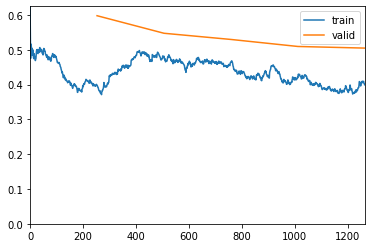

In [230]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

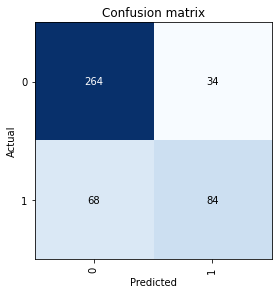

In [231]:
from fastai.version import *
preds, y, losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
interp.plot_confusion_matrix()


In [ ]:
train.head()


,id,text,HS,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
1,202,Why would young fighting age men be the vast m...,1,0,0
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
4,205,Orban in Brussels: European leaders are ignori...,0,0,0


In [ ]:
train[['text']].head(2).to_string()


"                                                                                                                                                                                                                                                                                                           text\n0                                                                                                                                                                                     Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike\n1  Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn"

Now, you can predict examples with:

In [ ]:
#learner.predict('This is the best movie of 2020')
learner.predict('@NBCPolitics @MSNBC After 20 days in jail the kids of the illigal refugees must get free. Than nobody should care to them and give them food. The only chance the whole familiy can go home and leave the USA. And sure it must made a supoer big wall to prote')


(Category tensor(1), tensor(1), tensor([2.0708e-01, 7.9292e-01, 2.1292e-07]))

In [ ]:
learner.predict('Another immigrant sexual assault case being ignored by the MSM. https://t.co/4NUNEDTzNP')


(Category tensor(0), tensor(0), tensor([9.9665e-01, 3.3454e-03, 1.3037e-07]))

## Export Learner
In order to export and load the learner you can do these operations:

In [ ]:
learner.export(file = 'transformer.pkl');


In [ ]:
#path = '/kaggle/working'
#export_learner = load_learner(path, file = 'transformer.pkl')

path = ''
export_learner = load_learner(path, file = 'transformer.pkl')

As mentioned [here](https://docs.fast.ai/basic_train.html#load_learner), you have to be careful that each custom classes - like ``TransformersVocab`` - are first defined before executing ``load_learner``.

In [ ]:
#export_learner.predict('This is the worst movie of 2020')
export_learner.predict('Another immigrant sexual assault case being ignored by the MSM. https://t.co/4NUNEDTzNP')


(Category tensor(0), tensor(0), tensor([9.6914e-01, 3.0853e-02, 7.6895e-06]))

## Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

As specified in Keita Kurita's [article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/), as the function ``get_preds`` does not return elements in order by default, you will have to resort the elements into their correct order.

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)


In [ ]:
'''
sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)
'''

sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['HS'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)


'\nsample_submission = pd.read_csv(DATA_ROOT / \'sampleSubmission.csv\')\nsample_submission[\'Sentiment\'] = np.argmax(test_preds,axis=1)\nsample_submission.to_csv("predictions.csv", index=False)\n'

We check the order.

In [ ]:
test.head()

,id,text,HS,TR,AG
0,18201,I swear I’m getting to places just in the nick...,0,0,0
1,18202,I’m an immigrant — and Trump is right on immig...,0,0,0
2,18203,#IllegalImmigrants #IllegalAliens #ElectoralSy...,1,0,1
3,18204,@DRUDGE_REPORT We have our own invasion issues...,1,0,1
4,18205,Worker Charged With Sexually Molesting Eight C...,0,0,0


In [ ]:
sample_submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [ ]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predictions.csv')

We can now submit our predictions to Kaggle !  In our example, without playing too much with the parameters, we get a score of 0.70059, which leads us to the 5th position on the leaderboard! 

# References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)